In [1]:
import time
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import kron
from scipy.sparse import eye
from scipy.sparse import linalg
from scipy.sparse.linalg import eigs
from scipy.linalg import block_diag
from scipy.linalg import norm
from scipy.linalg import solve
from typing import Union
import matplotlib.pyplot as plt

In [2]:
# Generate the matirx A
def lcd(beta, gamma, N):
    ee = np.ones((1,N))
    a = 5
    b = -1 - gamma
    c = -1 - beta
    d = -1 + beta
    e = -1 + gamma
    t1 = sparse.spdiags(np.vstack([c*ee, a*ee, d*ee]), np.arange(-1,2), N, N)
    t2 = sparse.spdiags(np.vstack([b*ee, np.zeros((1,N)), e*ee]), np.arange(-1,2), N, N)
    matrix = sparse.kron(sparse.eye(N,N),t1) + sparse.kron(t2,sparse.eye(N,N))
    return matrix

A = lcd(0.1, 0.1, 20).todense()

def sign(x):
    if x == 0: 
        return 0
    if x > 0:
        return 1
    else:
        return -1

In [3]:
def householder(A) -> Union[sp.matrix, sp.matrix]:
    m, n = A.shape # m*n matrix A
    R = sp.ndarray(A.shape)
    Q = sp.identity(m)
    eR = A.copy()

    for i in range(min(A.shape)):
        a = eR[:, 0] 
        e1 = sp.zeros(a.shape[0], dtype='float32')
        e1[0] = 1 
        
        # householder
        u = a + sign(a.item(0)) * norm(a) * e1 
        u = u / norm(u)
        H4 = sp.identity(a.shape[0]) - 2 * sp.outer(u, u) 
        H = block_diag(np.identity(i), H4)

        Q = H @ Q
        eR = H4 @ eR

        R[i,i:] = eR[0,:]
        R[i:,i] = eR[:,0]
        eR = eR[1:,1:]
        
    Q = Q.T # transpose of Q
    Q = Q[:, :n]
    R = R[:n, :]
    return (Q, R)

In [4]:
def full_gmres(A, b, x0, ite):
    
    m, n = A.shape
    r0 = b - A @ x0
    r0_norm = norm(r0)    
    q1 = r0 / r0_norm
    H = sp.ndarray((1, 0))
    Q = q1.reshape((n, 1))
    b_norm = norm(b)
    
    k = 0
    while True:
        k += 1
        h = sp.ndarray((k, 1))
        
        # Arnoldi Process
        j = k
        qj = Q[:,j-1]
        z = A @ qj
        for i in range(j):
            qi = Q[:, i]
            h[i, 0] = (qi.T @ z).item()
            z -= h[i, 0] * qi 
        hn = norm(z)
        qn= z / hn
        
        H = sp.block([[H, h],[sp.zeros((1, H.shape[1])), hn]])

        e1 = sp.zeros((k+1, 1))
        e1[0,0] = 1
        U, R = householder(H)
        yj = solve(R, norm(r0) * U.T @ e1)
        xj = x0 + Q @ yj # derive result
        
        Q = sp.hstack([Q, qn])
        rj_norm = r0_norm * sp.sqrt(1 - norm(U.T @ e1)**2)
        res1.append(rj_norm/b_norm) # record residuals

        if k > ite:
            break 

In [5]:
def restart_gmres(A, b, x0, restart, ite):
    num = 1
    
    m, n = A.shape
    r0 = b - A @ x0
    r0_norm = norm(r0)    
    q1 = r0 / r0_norm
    H = sp.ndarray((1, 0))
    Q = q1.reshape((n, 1))
    b_norm = norm(b)
    k = 0
    
    while True:
        k += 1
        h = sp.ndarray((k, 1))
        
        # Arnoldi Process
        j = k
        qj = Q[:,j-1]
        z = A @ qj
        for i in range(j):
            qi = Q[:, i]
            h[i, 0] = (qi.T @ z).item()
            z -= h[i, 0] * qi 
        hn = norm(z)
        qn= z / hn
        
        H = sp.block([[H, h],[sp.zeros((1, H.shape[1])), hn]])

        e1 = sp.zeros((k+1, 1))
        e1[0,0] = 1
        U, R = householder(H)
        yj = solve(R, norm(r0) * U.T @ e1)
        xj = x0 + Q @ yj # derive result
        
        Q = sp.hstack([Q, qn])
        rj_norm = r0_norm * sp.sqrt(1 - norm(U.T @ e1)**2)
        res3.append(rj_norm/b_norm) # record residuals
        
        if k < restart:
            if num > ite:
                break
            else: 
                num += 1
        else:
            x0 = xj
            r0 = b - A @ x0
            r0_norm = norm(r0)
            q1 = r0 / r0_norm
            H = sp.ndarray((1, 0))
            Q = q1.reshape((n, 1))
            k = 0
            num += 1

In [6]:
# Matirx and parameters
A = lcd(0.1, 0.1, 100).todense()
b = A @ sp.ones((A.shape[1], 1))
x0 = sp.zeros(b.shape)

res1 = []
full_gmres(A, b, x0, 100)
res3 = []
restart_gmres(A, b, x0, 20, 100)


<ipython-input-6-b9d32a589655>:3: DeprecationWarning: scipy.ones is deprecated and will be removed in SciPy 2.0.0, use numpy.ones instead
  b = A @ sp.ones((A.shape[1], 1))
<ipython-input-6-b9d32a589655>:4: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  x0 = sp.zeros(b.shape)
<ipython-input-4-adca3e59d16c>:27: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  H = sp.block([[H, h],[sp.zeros((1, H.shape[1])), hn]])
<ipython-input-4-adca3e59d16c>:27: DeprecationWarning: scipy.block is deprecated and will be removed in SciPy 2.0.0, use numpy.block instead
  H = sp.block([[H, h],[sp.zeros((1, H.shape[1])), hn]])
<ipython-input-4-adca3e59d16c>:29: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  e1 = sp.zeros((k+1, 1))
<ipython-input-3-ea44592c159c>:4: DeprecationWarning: scipy.identity is deprecated and will be remo

C:\Users\ariaq\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


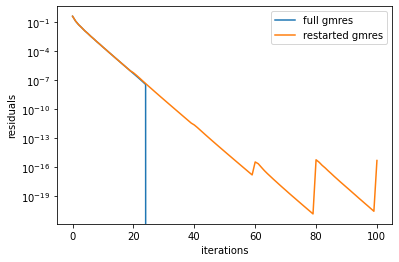

In [7]:
# Plot the comparation
plt.plot(range(len(res1)), res1, label='full gmres')
plt.plot(range(len(res3)), res3, label='restarted gmres')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('residuals')
plt.legend()

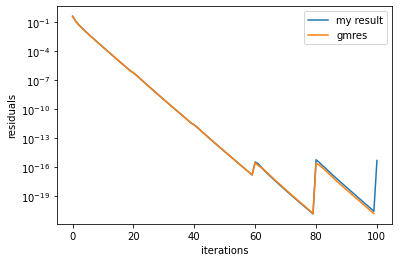

In [8]:
# Run GMRES function
from scipy.sparse.linalg import gmres
res2=[]
def gmres_res(r):
    res2.append(np.linalg.norm(r))
gmres(A, b, x0, callback=gmres_res, restart=20,tol=1e-20,maxiter=100)

# Plot the comparation
plt.plot(range(len(res3)), res3, label='my result')
plt.plot(range(len(res2)), res2, label='gmres')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('residuals')
plt.legend()